<a href="https://colab.research.google.com/github/ChangeEngine/Intro-to-ML--Group-1--Final-Project/blob/main/notebooks/02_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import sys
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

REPO_URL = "https://github.com/ChangeEngine/Intro-to-ML--Group-1--Final-Project.git"
REPO_DIR = Path("/content/Intro-to-ML--Group-1--Final-Project")

if "google.colab" in sys.modules:
    # Running in Google Colab
    if not REPO_DIR.exists():
        !git clone $REPO_URL $REPO_DIR
    os.chdir(REPO_DIR)

print("Working directory:", Path.cwd())

Working directory: /content/Intro-to-ML--Group-1--Final-Project


In [2]:
from pathlib import Path

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    alt = Path("..") / "data"
    if alt.exists():
        DATA_DIR = alt
    else:
        raise FileNotFoundError(
            "Could not find data/ folder at ./data or ../data. "
            "Make sure the repo has a data/ directory with the MNIST .gz files."
        )

print("Using data folder:", DATA_DIR.resolve())
print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)


Using data folder: /content/Intro-to-ML--Group-1--Final-Project/data
Files in data/:
 - t10k-images.idx3-ubyte.gz
 - t10k-labels.idx1-ubyte.gz
 - train-labels.idx1-ubyte.gz
 - train-images.idx3-ubyte.gz


In [3]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

plt.rcParams["figure.figsize"] = (4, 4)


train_images_path = DATA_DIR / "train-images.idx3-ubyte.gz"
train_labels_path = DATA_DIR / "train-labels.idx1-ubyte.gz"
test_images_path  = DATA_DIR / "t10k-images.idx3-ubyte.gz"
test_labels_path  = DATA_DIR / "t10k-labels.idx1-ubyte.gz"

(train_images_path, train_labels_path, test_images_path, test_labels_path)


(PosixPath('data/train-images.idx3-ubyte.gz'),
 PosixPath('data/train-labels.idx1-ubyte.gz'),
 PosixPath('data/t10k-images.idx3-ubyte.gz'),
 PosixPath('data/t10k-labels.idx1-ubyte.gz'))

In [4]:
def load_mnist_images(path):
    """Load MNIST images from an idx3-ubyte.gz file."""
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:16], dtype=">i4")
    magic, num_images, rows, cols = header
    assert magic == 2051, "Not an images file"

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images


def load_mnist_labels(path):
    """Load MNIST labels from an idx1-ubyte.gz file."""
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:8], dtype=">i4")
    magic, num_labels = header
    assert magic == 2049, "Not a labels file"

    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels


def load_mnist_dataset(images_path, labels_path, normalize=True):
    X = load_mnist_images(images_path)
    Y = load_mnist_labels(labels_path)

    if normalize:
        X = X.astype("float32") / 255.0

    return X, Y


In [5]:
X_train, y_train = load_mnist_dataset(train_images_path, train_labels_path)
X_test, y_test   = load_mnist_dataset(test_images_path, test_labels_path)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_test :", y_test.shape, y_test.dtype)

# Flatten 28x28 -> 784 features
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat :", X_test_flat.shape)


X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
X_test : (10000, 28, 28) float32
y_test : (10000,) uint8
X_train_flat: (60000, 784)
X_test_flat : (10000, 784)


In [6]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_flat,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train subset:", X_tr.shape, y_tr.shape)
print("Val subset  :", X_val.shape, y_val.shape)


Train subset: (48000, 784) (48000,)
Val subset  : (12000, 784) (12000,)


In [8]:
# Logistic Regression with lighter GridSearchCV (baseline model)

logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=100,
        n_jobs=-1,
    )),
])

param_grid = {
    "logreg__C": [0.5, 1.0, 2.0],
}


X_tr_sub = X_tr[:20000]
y_tr_sub = y_tr[:20000]

grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print("Running GridSearchCV for Logistic Regression on subset of", X_tr_sub.shape[0], "samples...")
grid_logreg.fit(X_tr_sub, y_tr_sub)
print("Done.")

print("Best params:", grid_logreg.best_params_)
print("Best CV macro F1:", grid_logreg.best_score_)


Running GridSearchCV for Logistic Regression on subset of 20000 samples...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Done.
Best params: {'logreg__C': 0.5}
Best CV macro F1: 0.8819034164741034


In [9]:
best_logreg = grid_logreg.best_estimator_

# --- Validation performance ---
y_val_pred = best_logreg.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
val_prec_macro, val_rec_macro, val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="macro"
)
val_prec_weighted, val_rec_weighted, val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="weighted"
)

print("VALIDATION RESULTS (Logistic Regression)")
print("Accuracy            :", val_acc)
print("Precision (macro)   :", val_prec_macro)
print("Recall (macro)      :", val_rec_macro)
print("F1-score (macro)    :", val_f1_macro)
print("Precision (weighted):", val_prec_weighted)
print("Recall (weighted)   :", val_rec_weighted)
print("F1-score (weighted) :", val_f1_weighted)

# --- Test performance ---
y_test_pred = best_logreg.predict(X_test_flat)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec_macro, test_rec_macro, test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="macro"
)
test_prec_weighted, test_rec_weighted, test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="weighted"
)

print("\nTEST RESULTS (Logistic Regression)")
print("Accuracy            :", test_acc)
print("Precision (macro)   :", test_prec_macro)
print("Recall (macro)      :", test_rec_macro)
print("F1-score (macro)    :", test_f1_macro)
print("Precision (weighted):", test_prec_weighted)
print("Recall (weighted)   :", test_rec_weighted)
print("F1-score (weighted) :", test_f1_weighted)

print("\nClassification report (test):\n")
print(classification_report(y_test, y_test_pred))


VALIDATION RESULTS (Logistic Regression)
Accuracy            : 0.89925
Precision (macro)   : 0.8979366846418539
Recall (macro)      : 0.8979538910682185
F1-score (macro)    : 0.8978265255302389
Precision (weighted): 0.8989576903065085
Recall (weighted)   : 0.89925
F1-score (weighted) : 0.8989823456279673

TEST RESULTS (Logistic Regression)
Accuracy            : 0.9051
Precision (macro)   : 0.9039129538713573
Recall (macro)      : 0.9037884634383426
F1-score (macro)    : 0.9037166344643932
Precision (weighted): 0.9049228032985055
Recall (weighted)   : 0.9051
F1-score (weighted) : 0.9048754736154511

Classification report (test):

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       980
           1       0.95      0.98      0.96      1135
           2       0.91      0.86      0.88      1032
           3       0.88      0.89      0.88      1010
           4       0.92      0.90      0.91       982
           5       0.87      0.85     

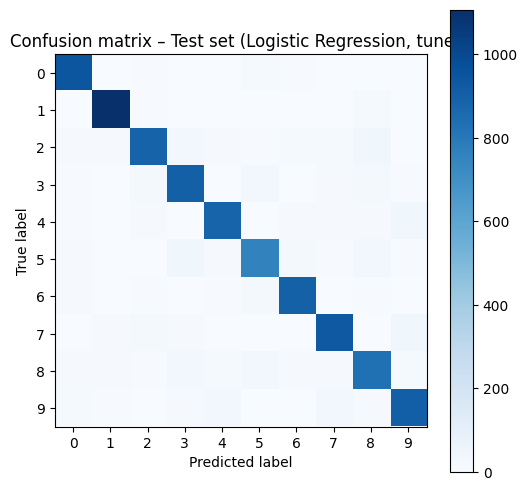

In [10]:
import numpy as np

cm_logreg = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm_logreg, cmap="Blues")
plt.title("Confusion matrix – Test set (Logistic Regression, tuned)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
